<a href="https://colab.research.google.com/github/byi8220/unsloth-puzzles/blob/main/Problem5/Unsloth_Problem_5_Llama_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsloth Problem 5 - Memory Efficient Backprop on Llama 3.2 1B SFT

#### Ran on a colab L4 GPU instance with 53 GB VRAM, 24 GB RAM

This is a reproduction of Unsloth's [LLama 3.2 1B notebook](https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing) comparing `MemoryEfficientLinear` patched in for the out projection with a base LLama 3.2 1B model.

This is quite hacky as we are fusing the loss function into the model.

In [1]:
%%capture
# Code to install Unsloth, Triton, Torch etc
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install unsloth vllm
!pip install flash-attn --no-build-isolation
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

!pip install ipywidgets # Needed to export to github

In [2]:
# Deterministic behavior between models
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # Needed for CE Loss
import torch
torch.manual_seed(3407)
torch.use_deterministic_algorithms(True)
torch.utils.deterministic.fill_uninitialized_memory = True

### Patch MemoryEfficientLinear into `new_model`

In [3]:
#@title MemoryEfficientLinear Implementation
device = "cuda"
import torch.nn.functional as F
import math

class MemoryEfficientLinear(torch.autograd.Function):
    # IMO, the spec is a bit vague, and I interpreted the arguments to
    # as MemoryEfficientLinear.forward(X, W, labels, fn) = fn(XW, labels)
    @staticmethod
    # (bsz, qlen, hd) @ (hd, vocab) -> (bsz, qlen, vocab)
    def forward(ctx, X, W, labels, forward_function, mel_num_chunks=1, ignore_index=-100):
        # NOTE: I wasn't sure what `allows_dynamic_chunk_sizes` means here.
        # I interpreted it to mean "let the user specify the number of chunks,
        # and the chunks will be sized accordingly."
        ctx.mel_num_chunks = mel_num_chunks # How to chunk `XW` over batches

        # Perform `forward_function` in chunks, and reduce them into `output`
        output = 0.0

        # Require uniform chunk size, for cleaner computations involving
        # `ForCausalLMLoss` and `num_items_in_batch`.
        assert X.shape[0] % ctx.mel_num_chunks == 0
        assert ctx.mel_num_chunks <= X.shape[0]
        b_per_chunk = X.shape[0] // ctx.mel_num_chunks

        N = 0
        for b in range(ctx.mel_num_chunks):
            b0, b1 = b *  b_per_chunk, (b+1) * b_per_chunk
            # Reduce (bsz, qlen, vocab) to (b_per_chunk, q_per_chunk, vocab)
            with torch.no_grad():
                X_slice = X[b0:b1]
                l_slice = labels[b0:b1]
                XW_slice = (F.linear(X_slice, W.T)).float()
            output += torch.numel(l_slice) * forward_function(XW_slice, l_slice)
            N += torch.numel(l_slice)
        del XW_slice
        ctx.save_for_backward(X, W, labels)
        ctx.forward_function = forward_function
        ctx.N = N
        ctx.ignore_index = ignore_index
        return output / N

    # L(X,W,T,f) = f(XW, T)
    # dL/dX = dL/df * df/d(XW) * d(XW)/dX
    # dL/dW = dL/df * df/d(XW) * d(XW)/dW
    # We want to avoid materializing df/d(XW) to save on memory,
    # as XW is the large tensor we are trying to avoid materializing
    @staticmethod
    def backward(ctx, dY):

        # As written we need to retain at least all of X, W, labels
        # (This could possibly be optimized more)
        X, W, labels = ctx.saved_tensors

        # The absolute minimum memory usage this function can possibly incur is
        # that required for the returned gradients.
        dX = torch.zeros_like(X)
        dW = torch.zeros_like(W)
        assert X.shape[0] % ctx.mel_num_chunks == 0
        assert ctx.mel_num_chunks <= X.shape[0]
        b_per_chunk = X.shape[0] // ctx.mel_num_chunks

        for b in range(ctx.mel_num_chunks):
            b0, b1 = b * b_per_chunk, (b+1) * b_per_chunk
            X_slice = X[b0:b1].detach().requires_grad_()
            W_slice = W.detach().requires_grad_()
            l_slice = labels[b0:b1].detach()
            with torch.enable_grad():
                XW_slice = (F.linear(X_slice, W_slice.T)).float()
                out = ctx.forward_function(XW_slice, l_slice) * torch.numel(l_slice)
            # From my testing this appears to use more memory than hardcoded matmul (sometimes)
            dX_slice, dW_slice = torch.autograd.grad(out, (X_slice, W_slice), dY / ctx.N, retain_graph=False, create_graph=False)
            dX[b0:b1] = dX_slice.to(dX.dtype)
            dW += dW_slice.to(dW.dtype)

        return dX, dW, None, None, None, None


In [4]:
import torch
max_seq_length = 512
dtype = torch.bfloat16
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

### Presumably we're testing base, unpatched LLama.
# tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
# reference_model = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct").to(dtype).to(device)
# mem_eff_model = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct").to(dtype).to(device)
import torch
dtype = torch.bfloat16
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig

## Presumably we're testing base LLama.
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
peft_config = LoraConfig(
    r=16,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
)
reference_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-1B-Instruct",
    torch_dtype=dtype,
    attn_implementation="flash_attention_2",
    ).to(device)

mem_eff_model = AutoModelForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-1B-Instruct",
    torch_dtype=dtype,
    attn_implementation="flash_attention_2",
    ).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
#@title MemoryEfficientLinear Patch
# Model based on https://github.com/huggingface/transformers/blob/51083d1bac7905aa8316b75f7897bdd4e5302044/src/transformers/models/llama/modeling_llama.py#L752
from typing import Callable, List, Optional, Tuple, Union
from transformers.models.llama.modeling_llama import LlamaForCausalLM, KwargsForCausalLM,LlamaModel
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers.cache_utils import Cache
from transformers.loss.loss_utils import ForCausalLMLoss
from transformers.processing_utils import Unpack
from transformers.utils.deprecation import deprecate_kwarg
from functools import partial
import torch.nn as nn

# In new_model, we are fusing the loss function and the final linear projection
# into one layer.
NUM_MEL_CHUNKS = 2

@deprecate_kwarg("num_logits_to_keep", version="4.50", new_name="logits_to_keep")
def mem_eff_forward(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    cache_position: Optional[torch.LongTensor] = None,
    logits_to_keep: Union[int, torch.Tensor] = 0,
    **kwargs: Unpack[KwargsForCausalLM],
) -> Union[Tuple, CausalLMOutputWithPast]:
    r"""
        Near identical to `LLamaForCausalLM.forward()`, except:
          1. In training mode, loss is computed via `MemoryEfficientLinear`, and logits are not returned.
          2. In eval mode, the model behaves identically to `LLamaForCausalLM`.
    """
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    outputs = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        cache_position=cache_position,
        **kwargs,
    )

    hidden_states = outputs[0]
    # Only compute necessary logits, and do not upcast them to float if we are not computing the loss
    slice_indices = slice(-logits_to_keep, None) if isinstance(logits_to_keep, int) else logits_to_keep

    logits, loss = None, None
    # [ForCausalLMLoss](https://github.com/huggingface/transformers/blob/51083d1bac7905aa8316b75f7897bdd4e5302044/tests/trainer/test_trainer.py#L189)
    # The default loss function, ForCausalLMLoss uses mean reduction.
    memEffLinear = MemoryEfficientLinear.apply
    if labels is not None:
        # ForCausalLMLoss utilizes the "num_items_in_batch" kwarg passed in
        # via the `Trainer` to normalize the computed cross entropy loss.
        # This completely throws off our calculation since we expect
        # `forward_function()` to return the mean of only the provided args.
        #
        # The solution below is hacky, but we can scale forward_function()
        # by its contribution to the accumulated loss
        loss =  memEffLinear(hidden_states[:, slice_indices, :], self.lm_head.weight.T,
                            labels,
                            partial(ForCausalLMLoss, vocab_size=self.config.vocab_size, **kwargs),
                            NUM_MEL_CHUNKS)
        if "num_items_in_batch" in kwargs:
            loss = loss * NUM_MEL_CHUNKS
    if not self.training:
        logits = self.lm_head(hidden_states[:, slice_indices, :])
    if not return_dict:
        output = (logits,) + outputs[1:]
        return (loss,) + output if loss is not None else output
    return CausalLMOutputWithPast(
        loss=loss,
        logits=logits,
        past_key_values=outputs.past_key_values,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

# Model patching
import types
setattr(mem_eff_model, "forward", types.MethodType(mem_eff_forward, mem_eff_model))
for p1, p2 in zip(mem_eff_model.parameters(), reference_model.parameters()):
    from torch.testing import assert_close
    assert_close(p1, p2)


In [6]:
inputs = torch.randint(0, 10, (NUM_MEL_CHUNKS, 6), dtype=torch.long).to(device)
labels = torch.randint(0, 10, (NUM_MEL_CHUNKS, 6), dtype=torch.long).to(device)

o1 = reference_model(input_ids=inputs, labels=labels, past_key_values=None)
o2 = mem_eff_model(input_ids=inputs, labels=labels, past_key_values=None)

torch.testing.assert_close(o1.loss, o2.loss)

<a name="Data"></a>
### Data Prep
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

In [7]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

<ipython-input-7-623719143531>:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.chat_templates import get_chat_template


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-09 22:36:43 [__init__.py:239] Automatically detected platform cuda.


README.md:   0%|          | 0.00/982 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [8]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Standardizing formats (num_proc=12):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

We look at how the conversations are structured for item 5:

In [9]:
dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

In [10]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [11]:
# Create a trainer for both the reference and new mocdels
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

ref_trainer = SFTTrainer(
    model = reference_model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "reference_outputs",
        report_to = "none", # Use this for WandB etc
    ),
    peft_config = peft_config,
)

new_trainer = SFTTrainer(
    model = mem_eff_model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "mem_eff_outputs",
        report_to = "none", # Use this for WandB etc
    ),
    peft_config = peft_config,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [12]:
from unsloth.chat_templates import train_on_responses_only
ref_trainer = train_on_responses_only(
    ref_trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

new_trainer = train_on_responses_only(
    new_trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=12):   0%|          | 0/100000 [00:00<?, ? examples/s]

We verify masking is actually done:

In [13]:
tokenizer.decode(ref_trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight rel

In [14]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in ref_trainer.train_dataset[5]["labels"]])

'                                                                  Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [15]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
8.082 GB of memory reserved.


In [16]:
#@title Train the reference
ref_trainer_stats = ref_trainer.train()

Step,Training Loss
1,0.917500
2,1.156400
3,0.996400
4,1.027900
5,1.206500
6,1.297900
7,1.309900
8,1.435000
9,1.597200
10,1.424400


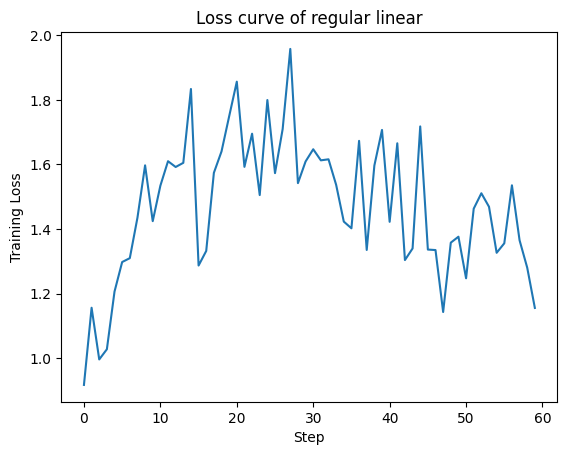

In [17]:
#@title Show and export loss curve (reference)
import matplotlib.pyplot as plt
ref_train_loss = []
for elem in ref_trainer.state.log_history:
    if 'loss' in elem.keys():
        ref_train_loss.append(elem['loss'])
plt.plot(ref_train_loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Loss curve of regular linear")
plt.savefig("regular_llama_1b_loss_curve.png")
plt.show("png")

In [18]:
#@title Show final memory and time stats (reference)
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_percentage = round(used_memory /max_memory*100, 3)
print(f"{ref_trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(ref_trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")

162.5076 seconds used for training.
2.71 minutes used for training.
Peak reserved memory = 7.674 GB.
Peak reserved memory % of max memory = 34.628 %.


In [19]:
#@title Show current memory stats (new model)
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
7.674 GB of memory reserved.


In [20]:
#@title Train the new model
new_trainer_stats = new_trainer.train()

Step,Training Loss
1,0.917500
2,1.156400
3,0.997900
4,1.028400
5,1.208700
6,1.296000
7,1.312100
8,1.436200
9,1.597300
10,1.424500


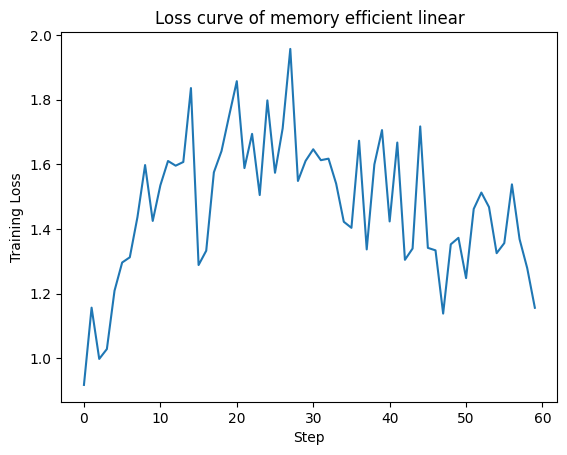

In [21]:
#@title Show and export loss curve (memory efficient linear)
import matplotlib.pyplot as plt
me_train_loss = []
for elem in new_trainer.state.log_history:
    if 'loss' in elem.keys():
        me_train_loss.append(elem['loss'])
plt.plot(me_train_loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Loss curve of memory efficient linear")
plt.savefig("memory_efficient_llama_1b_loss_curve.png")
plt.show("png")

In [22]:
#@title Show final memory and time stats (new model)
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_percentage = round(used_memory/max_memory*100, 3)
print(f"{new_trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(new_trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")

171.9944 seconds used for training.
2.87 minutes used for training.
Peak reserved memory = 18.393 GB.
Peak reserved memory % of max memory = 82.997 %.


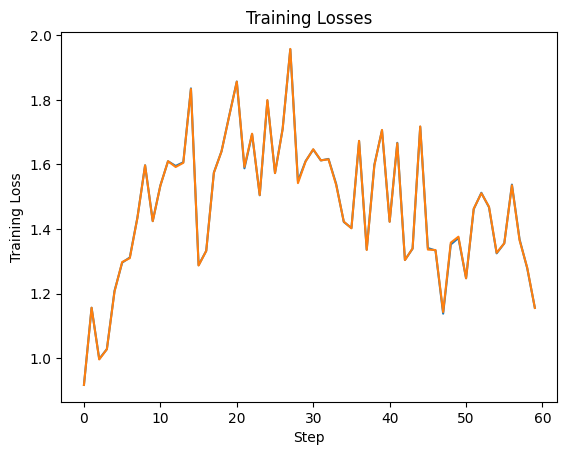

In [23]:
#@title Show and export drift between loss curves
import matplotlib.pyplot as plt
diff = [ref_train_loss[i] - me_train_loss[i] for i in range(len(me_train_loss))]
plt.plot(me_train_loss, label="Memory Efficient")
plt.plot(ref_train_loss, label="Regular")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Losses")
plt.savefig("llama_1b_loss_curves.png")
plt.show("png")

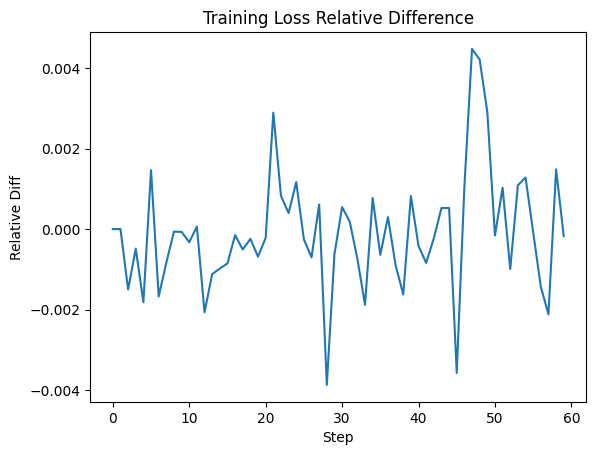

In [24]:
#@title Show and export drift between loss curves
import matplotlib.pyplot as plt
eps = 1e-6
rel = [(ref_train_loss[i]- me_train_loss[i]) / (me_train_loss[i]+eps) for i in range(len(me_train_loss))]
plt.plot(rel, label="Memory Efficient")
plt.xlabel("Step")
plt.ylabel("Relative Diff")
plt.title("Training Loss Relative Difference")
plt.savefig("llama_1b_loss_difference.png")
plt.show("png")